In [1]:
# happyleaf
# main.ipynb

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import model as m

np.random.seed(41)

In [3]:
with open("numpydata.pkl", "rb") as f:
    (xs_all, data_indices_all) = pickle.load(f)

img_size = xs_all.shape[1]
total_img_num = xs_all.shape[0]
num_categories = data_indices_all.shape[1]

def unison_shuffled(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def prepare_batch(xs_h, data_indices_h, u, v):
    len_tot = xs_h.shape[0]
    u_tr, v_tr = u % len_tot, v % len_tot
    if v_tr + len_tot - u_tr == v - u:
        xs_first = xs_h[u_tr:len_tot, ...]
        d_first = data_indices_h[u_tr:len_tot, ...]
        unison_shuffled(xs_h, data_indices_h)
        xs_second = xs_h[0:v_tr, ...]
        d_second = data_indices_h[0:v_tr, ...]
        xs_o = np.concatenate([xs_first, xs_second])
        data_indices_o = np.concatenate([d_first, d_second])
    else:
       xs_o = xs_h[u_tr:v_tr, ...]
       data_indices_o = data_indices_h[u_tr:v_tr, ...]
    return jnp.array(xs_o), jnp.array(data_indices_o)

unison_shuffled(xs_all, data_indices_all)

u, v = int(0.8 * total_img_num), int(0.9 * total_img_num)
xs_train, data_indices_train = xs_all[:u, ...], data_indices_all[:u, ...]
xs_val, data_indices_val = xs_all[u:v, ...], data_indices_all[u:v, ...]
xs_test, data_indices_test = xs_all[v:, ...], data_indices_all[v:, ...]

print(f"Dataset sizes: train {u}, val {v - u}, test {total_img_num - v}")
print(f"Categories: {num_categories}")

Dataset sizes: train 49188, val 6149, test 6149
Categories: 39


In [4]:
model = m.MainModel()

model.val_arr = [[jnp.log(num_categories), 1 / num_categories]]
model.train_arr = model.val_arr.copy()
model.test_loss = 0.0
model.test_classify = 0.0

total = 50000
batch_size = 64

print(f"Number of parameters: {model.total_params()}")
print(f"Random picks: loss {model.val_arr[0][0]}, classify = {model.val_arr[0][1]}")

Number of parameters: 119845
Random picks: loss 3.6635615825653076, classify = 0.02564102564102564


In [5]:
# Training

# with jax.disable_jit():
for i in range(1, total + 1):
    u, v = (i - 1) * batch_size, i * batch_size
    # u, v = 0, batch_size # Overfit for debugging
    xs_t, data_indices_t = prepare_batch(xs_train, data_indices_train, u, v)
    xs_v, data_indices_v = prepare_batch(xs_val, data_indices_val, u, v)
    if i < 2001:
        # Warmup phase (i from 1 to 2001)
        model.adam_lr = 2e-4
    else:
        # Exponential learning rate decay from 8e-5 down to 2e-5 (i from 2001 to 6001)
        model.adam_lr = 8e-5 * jnp.power(2.0, -min(i - 2001, 4000) / 2000)
    model.adamw_update(xs_t, data_indices_t)
    # Print current train and validation loss
    model.update_loss_and_classify(model.train_arr, xs_t, data_indices_t)
    model.update_loss_and_classify(model.val_arr, xs_v, data_indices_v)
    if i % 100 == 0:
        print(f"Run {i * batch_size}: train loss {model.train_arr[-1][0]}, classify {model.train_arr[-1][1]}")
        print(f"Run {i * batch_size}: val loss {model.val_arr[-1][0]}, classify {model.val_arr[-1][1]}")

with open(f"checkpoints/modelcheck-{total}.pkl", "wb") as f:
    pickle.dump(model, f)

Run 6400: train loss 3.2320704460144043, classify 0.16348710656166077
Run 6400: val loss 3.184725522994995, classify 0.18490125238895416
Run 12800: train loss 2.5554802417755127, classify 0.30821493268013
Run 12800: val loss 2.604909896850586, classify 0.30091315507888794
Run 19200: train loss 2.221062421798706, classify 0.38603752851486206
Run 19200: val loss 2.2465567588806152, classify 0.3901450037956238
Run 25600: train loss 2.0874619483947754, classify 0.412085622549057
Run 25600: val loss 2.194631814956665, classify 0.3840399384498596
Run 32000: train loss 2.044651985168457, classify 0.43219929933547974
Run 32000: val loss 2.049119234085083, classify 0.42427465319633484
Run 38400: train loss 1.862437129020691, classify 0.46506622433662415
Run 38400: val loss 2.044295310974121, classify 0.4007043242454529
Run 44800: train loss 1.898861050605774, classify 0.45580002665519714
Run 44800: val loss 1.903336524963379, classify 0.471967488527298
Run 51200: train loss 1.7217243909835815, 

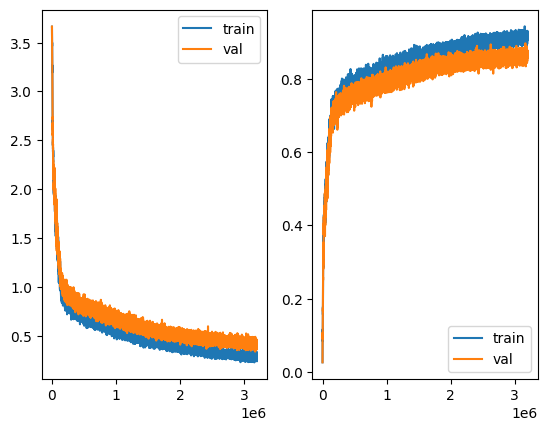

In [6]:
%matplotlib inline
fig, (ax_l, ax_r) = plt.subplots(1, 2)
ax_l.plot(batch_size * np.arange(0, total + 1), [ t[0] for t in model.train_arr ], label = "train")
ax_l.plot(batch_size * np.arange(0, total + 1), [ t[0] for t in model.val_arr ], label = "val")
ax_r.plot(batch_size * np.arange(0, total + 1), [ t[1] for t in model.train_arr ], label = "train")
ax_r.plot(batch_size * np.arange(0, total + 1), [ t[1] for t in model.val_arr ], label = "val")
ax_l.legend()
ax_r.legend();

In [7]:
# Report test error

# Load checkpoint (not necessary if training loop was executed)
with open(f"checkpoints/modelcheck-{total}.pkl", "rb") as f:
    model = pickle.load(f)

loop_num = xs_test.shape[0] // batch_size

model.test_loss = 0.0
model.test_classify = 0.0

for i in range(0, loop_num):
    u, v = i * batch_size, (i + 1) * batch_size
    xs, data_indices = prepare_batch(xs_test, data_indices_test, u, v)
    model.test_loss += model.forward_loss_batched(xs, data_indices)
    model.test_classify += model.forward_classify_batched(xs, data_indices)

model.test_loss /= loop_num
model.test_classify /= loop_num

with open(f"checkpoints/modelcheck-{total}.pkl", "wb") as f:
    pickle.dump(model, f)

print(f"Final: test loss {model.test_loss}, classify {model.test_classify}")

Final: test loss 0.42871150374412537, classify 0.8670247793197632
